# House Prices - Advanced Regression Techniques

## Predict sales prices and practice feature engineering, RFs, and gradient boosting

# Introduction

**Objective and Framework**  
With a professional background spanning over seven years in the real estate and finance sectors, I embarked on a comprehensive study of the Kaggle competition dataset: "House Prices - Advanced Regression Techniques."

**Dataset**  
This dataset comprises 1460 training and 1459 test samples, each equipped with 80 features, covering a wide range from SquareFoot area to Garage specifications. The primary objective is to predict SalePrices, making it a challenging yet intriguing task.

**Overview**  
In this study, the core focus was on meticulous data exploration, creative feature engineering, and a thorough analysis of what truly drives property prices. Outliers were addressed, revealing intriguing patterns in the residuals. Deeper analysis pointed towards a more aggressive approach to outlier removal, leading to a remarkable performance boost of nearly 10%.

A pivotal transformation was applied to the Neighborhood feature, converting it into median house prices to capture the locality's impact on property values. Additionally, the study delved into multivariate analysis, carefully weighing feature retention against elimination.

The modeling phase encompassed five diverse algorithms—linear regression, ridge regression, lasso regression, random forest regression, and gradient boosting regression. After rigorous cross-validation, gradient boosting emerged as the standout performer. Fine-tuning hyperparameters and optimization with further feature engineering culminated in an impressive 0.11 RMSE, underscoring the efficacy of this approach in predicting house prices.

**Key Findings**  
Key findings were abundant during this study, highlighting the substantial influence of 'Overall Quality', 'Median House Price', and 'Living Area' on Sale Prices. Moreover, 'External Quality', 'Garage Area' and 'total Bathrooms' emerged as significant factors influencing property values.

**Challenges and Future Improvements**  
While this notebook already yields promising results, there's ample room for further enhancement. Future iterations could delve into features like property age and renovation year, and explore more sophisticated and layered modeling techniques.

# 1. Data Exploration and Preprocessing

## Load and Exploring the dataset

In [104]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [105]:
pd.set_option('display.max_columns', None)

In [106]:
df1 = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')
print(f"Train Data : {df1.shape}")
print(f"Test Data : {df_test.shape}")

Train Data : (1460, 81)
Test Data : (1459, 80)


I wanted to prevent **data leakage** since there will be some calculations accross datasets, possible imputations. Altough combinin two datasets is also a widely accepted method i prefered to work seperately. That's the reason we firstly check whether the datasets are aligned or not. We will check again after encoding in case dataset might have different columns

In [107]:
def is_columns_aligned(df1, df2):

    columns1 = set(df1.columns)
    columns2 = set(df2.columns)

    if columns1 == columns2:
        print("Train and test datasets have the same columns.")
    else:
        print("Train and test datasets have different columns.")
        print("Columns in train but not in test:", columns1 - columns2)
        print("Columns in test but not in train:", columns2 - columns1)

In [108]:
is_columns_aligned(df1, df_test)

Train and test datasets have different columns.
Columns in train but not in test: {'SalePrice'}
Columns in test but not in train: set()


## Handling Missing Values

I have a missing values class in my module related to exploratory data analysis to make things easier. Lets import and instantiate an handler

In [109]:
from data.fatih_eda import Dealing_missing_values

In [110]:
missing_handler = Dealing_missing_values(df1)

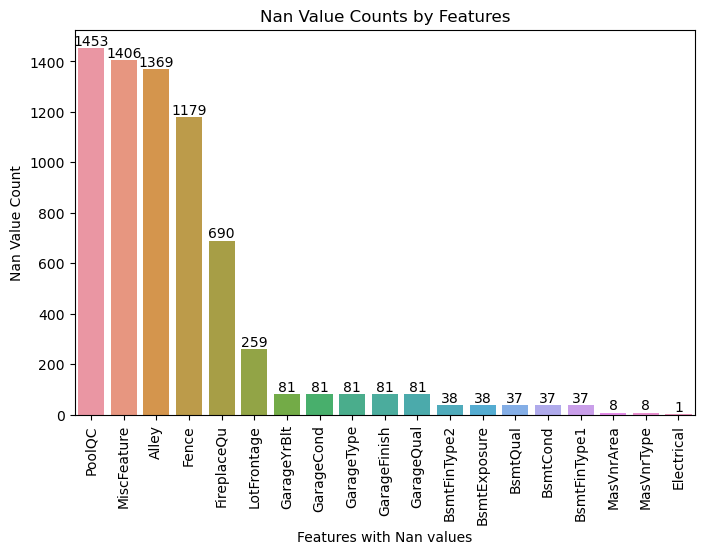

In [111]:
missing_handler.show_missing_values()

As we see above after checking the data description document, all of the missing values in train data actually not missing but meaning this feature is not exist in this property. Therefore i created and apply some replacements. But in the test data we observed some missing values and performed imputation with mode.

In [112]:
replacement_dictionary = {
                            'PoolQC'      : 'No Pool',
                            'MiscFeature' : 'No MiscFeatures',  
                            'Alley'       : 'No Alley Access',
                            'Fence'       : 'No Fence',
                            'FireplaceQu' : 'No FirePlace', 
                            'GarageFinish': 'No Garage',
                            'GarageQual'  : 'No Garage',
                            'GarageCond'  : 'No Garage',
                            'GarageType'  : 'No Garage',
                            'BsmtExposure': 'No Basement',
                            'BsmtCond'    : 'No Basement',
                            'BsmtQual'    : 'No Basement',
                            'BsmtFinType2': 'No Basement',
                            'BsmtFinType1': 'No Basement',
                            'Electrical'  : 'No Electrical',
                            'MasVnrType'  : 'No MasVnr',
                            'MasVnrArea'  : 0,
                            'LotFrontage' : 0,
                            'GarageYrBlt' : 0}

In [113]:
missing_handler.replace(replacement_dictionary)

In [114]:
missing_handler.show_missing_values()

There are no missing values


In [115]:
df2 = df1.copy()
print(df1.shape, ' ---> ', df2.shape)

(1460, 81)  --->  (1460, 81)


**Test Data**

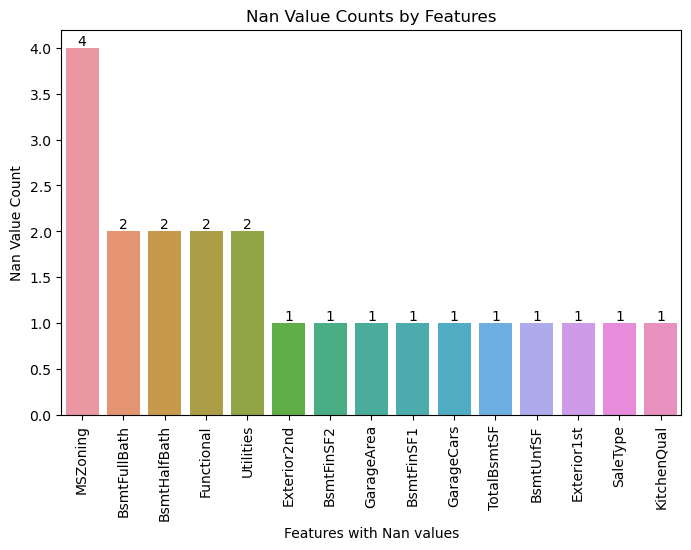

In [116]:
# For Test Data
missing_handler_test = Dealing_missing_values(df_test)
missing_handler_test.replace(replacement_dictionary)
missing_handler_test.show_missing_values()

In [117]:
# For Test Data
missing_handler_test = Dealing_missing_values(df_test)
missing_handler_test.replace(replacement_dictionary)
missing_handler_test.mmm(['MSZoning', 'Functional', 'Utilities', 'Exterior2nd', 'Exterior1st', 'SaleType', 'KitchenQual'], 'mode')

replacement_dictionary_test = {'BsmtFullBath':0, 'BsmtHalfBath':0, 'BsmtFinSF2':0, 'GarageArea':0, 'BsmtFinSF1':0, 'GarageCars':0, 'TotalBsmtSF':0, 'BsmtUnfSF':0}
missing_handler_test.replace(replacement_dictionary_test)
missing_handler_test.show_missing_values()

There are no missing values


In [118]:
df_test_2 = df_test.copy()
print(df_test.shape, ' ---> ', df_test_2.shape)

(1459, 80)  --->  (1459, 80)


## Feature Engineering

### Summarizing Features: Creating new Features and drop old ones

I have transformed, summarized or changed many columns here. But i think there are still **room for improvement in Age and Renovation Age,** with a keen eye on residuals models are not performing well with this two columns. It needs further investigation. Also, **TotalRmsAbvGr and BedroomAbvGr** can be used interchangebly to check for any effect. Because the effect of Bedrooms on the salePrice is not the same as Total Rooms. A bar plot will help for this purposes, but for a better correlation and better explanation i have selected Total Rooms feature 

In [119]:
# Hold 'GrLivArea' / drop '1stFlrSF', '2ndFlrSF'

# Hold 'TotRmsAbvGrd' / drop 'BedroomAbvGr'

# Create Total Bathrooms / drop 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath'
df2['Total_Bathrooms'] = df2['BsmtFullBath'] + df2['FullBath'] + 0.5*(df2['BsmtHalfBath'] + df2['HalfBath'])

# Create Age of the House / drop 'YearBuilt'
df2['Age_of_Property'] = df2['YearBuilt'].max() - df2['YearBuilt']

# Create 'Age_of_Renovation' / drop 'YearRemodAdd'
df2['Age_of_Renovation'] = df2['YearBuilt'].max() - df2['YearRemodAdd']

# Hold 'GarageArea', create 'Has_Garage' binary / drop 'GarageType','GarageYrBlt','GarageFinish','GarageCars','GarageQual','GarageCond'
df2['HasGarage'] = (df2['GarageType'] != 'No Garage').astype(int)

I want to create a new feature with **median prices for each neighborhood** and drop neighborhoods itself. Because generally, prices are tightly dependent on the neighborhood. We can also work with sqft prices as well. I have used pivots and **aggregation** methods here.

In [120]:
# Create 'Neibhborhood_MedianP' / drop 'Neighborhood'
neighborhood_median_price = df2.groupby('Neighborhood')['SalePrice'].median().reset_index()
neighborhood_median_price.columns = ['Neighborhood', 'MedianHousePrice']
df2 = pd.merge(df2, neighborhood_median_price, on='Neighborhood', how='left')

**There are a ton of basement features, but they really effect the prices. If you dont believe, check the correlation table with SalePrices below in EDA part. Therefore i spent some time on Basement Features. Here is my process:**   
- I will give grades to Basement Quality, Basement Condition, Basement Exposure
- I will combine Basement FinTypes and Sq Footage into one feature having a grade
- Then i will combine all 4 features into one feature **Ovarall Basement Quality** with a total grade
- if the grade is zero - that means no basement/ but we need to check all the columns have synchronized no basement values or not
- i will drop the remaining

**To reach this Overall Basement Quality, i dont want to miss any information, so I am thinking to make a combined Basement Finishing Type Feature.**  
- Firstly, we will map the string categories into grades in BsmtFinType1 and BsmtFinType2
- Secondly, We will normalize BsmtFinSF1, BsmtFinSF2, BsmtUnfSF because all totally makes TotalBsmtSF
- Thirdly, SF1 * TYPE1_GRADE + SF2 * TYPE2_GRADE + SF3 * 1 (1 is the grade score of unf category)
- Actually BsmtUnfSF column is a seperated value from other columns because the other two columns have unf categories as well
- For example, if BsmtFinType2 == Unf normally we are expecting BsmtFinSF2 have a float value. But in our dataset it comes 0.0 and the value is coming with a seperate column named BsmtUnfSF. So we assume that they are iconic 

**Finally i will have two features related to Basement:**  
- BsmtOverallGrade
- TotalBsmtSF

In [121]:
# Define different mappings for each basement features (because we will make math operations/grading)
bsmt_qual_mapping = {'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1, 'No Basement': 0}
bsmt_cond_mapping = {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'No Basement': 0}
bsmt_exposure_mapping = {'Gd': 4, 'Av': 3, 'Mn': 2, 'No': 1, 'No Basement': 0}
bsmt_fintype_mapping = {'GLQ': 6, 'ALQ': 5, 'BLQ': 4, 'Rec': 3, 'LwQ': 2, 'Unf': 1, 'No Basement': 0}

# Convert the categorical str values into grade points by mapping function
df2['BsmtFinType1'] = df2['BsmtFinType1'].map(bsmt_fintype_mapping)
df2['BsmtFinType2'] = df2['BsmtFinType2'].map(bsmt_fintype_mapping)
df2['BsmtQual'] = df2['BsmtQual'].map(bsmt_qual_mapping)
df2['BsmtCond'] = df2['BsmtCond'].map(bsmt_cond_mapping)
df2['BsmtExposure'] = df2['BsmtExposure'].map(bsmt_exposure_mapping)

# FinType has a numeric grade and a corresponding sqfoot, combine them
df2['BsmtFinGrade'] = (df2['BsmtFinType1'] * df2.BsmtFinSF1 / df2.TotalBsmtSF) + \
                      (df2['BsmtFinType2'] * df2.BsmtFinSF2 / df2.TotalBsmtSF) + \
                      (df2['BsmtFinType1'] * df2.BsmtUnfSF / df2.TotalBsmtSF)

# Because of zero division there will be Nan values where there are no basement, since TotalBsmtSf == 0
df2['BsmtFinGrade'].fillna(0.0, inplace=True)

# Combine into one single 'BsmtOverallGrade'
df2['BsmtOverallGrade'] = round((df2['BsmtQual'] + df2['BsmtCond'] + df2['BsmtExposure'] + df2['BsmtFinGrade']), 2)

# Drop :
# 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1','BsmtFinType2', 
# 'BsmtFinSF2','BsmtUnfSF','BsmtFinGrade'

A similar approah of basement, i approach to Deck or Porch features. Here i used some domain knowledge by the help of my real estate expertise and arrange **weighs** list for each feature, then i simply combined all similar features into one **single new feature**

In [122]:
# Create 'Terrace_Grade' / drop 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch'
terrace_columns = ['WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch']
terrace_weights = [1, 1, 2, 2, 2]

df2['Terrace_Grade'] = np.dot(df2[terrace_columns], terrace_weights)

__Dropping the columns__

In [123]:
col_drop_feat_eng = ['1stFlrSF', '2ndFlrSF', 'BedroomAbvGr',
                     'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 
                    'YearBuilt', 'YearRemodAdd', 
                    'GarageType','GarageYrBlt','GarageFinish','GarageCars','GarageQual','GarageCond',
                    'Neighborhood', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1','BsmtFinType2', 
                    'BsmtFinSF2','BsmtUnfSF','BsmtFinGrade',
                    'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch']

In [124]:
df3 = df2.drop(columns=col_drop_feat_eng)
df3.shape

(1460, 59)

**Test Data**

we are just applying the same process to test data

In [125]:
# Create Total Bathrooms / drop 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath'
df_test_2['Total_Bathrooms'] = df_test_2['BsmtFullBath'] + df_test_2['FullBath'] + 0.5*(df_test_2['BsmtHalfBath'] + df_test_2['HalfBath'])

# Create Age of the House / drop 'YearBuilt'
df_test_2['Age_of_Property'] = df_test_2['YearBuilt'].max() - df_test_2['YearBuilt']

# Create 'Age_of_Renovation' / drop 'YearRemodAdd'
df_test_2['Age_of_Renovation'] = df_test_2['YearBuilt'].max() - df_test_2['YearRemodAdd']

# Hold 'GarageArea', create 'Has_Garage' binary / drop 'GarageType','GarageYrBlt','GarageFinish','GarageCars','GarageQual','GarageCond'
df_test_2['HasGarage'] = (df_test_2['GarageType'] != 'No Garage').astype(int)

In [126]:
# Create 'Neibhborhood_MedianP' / drop 'Neighborhood'
df_test_2 = pd.merge(df_test_2, neighborhood_median_price, on='Neighborhood', how='left')

In [127]:
# Convert the categorical str values into grade points by mapping function
df_test_2['BsmtFinType1'] = df_test_2['BsmtFinType1'].map(bsmt_fintype_mapping)
df_test_2['BsmtFinType2'] = df_test_2['BsmtFinType2'].map(bsmt_fintype_mapping)
df_test_2['BsmtQual'] = df_test_2['BsmtQual'].map(bsmt_qual_mapping)
df_test_2['BsmtCond'] = df_test_2['BsmtCond'].map(bsmt_cond_mapping)
df_test_2['BsmtExposure'] = df_test_2['BsmtExposure'].map(bsmt_exposure_mapping)

# FinType has a numeric grade and a corresponding sqfoot, combine them
df_test_2['BsmtFinGrade'] = (df_test_2['BsmtFinType1'] * df_test_2.BsmtFinSF1 / df_test_2.TotalBsmtSF) + \
                      (df_test_2['BsmtFinType2'] * df_test_2.BsmtFinSF2 / df_test_2.TotalBsmtSF) + \
                      (df_test_2['BsmtFinType1'] * df_test_2.BsmtUnfSF / df_test_2.TotalBsmtSF)

# Because of zero division there will be Nan values where there are no basement, since TotalBsmtSf == 0
df_test_2['BsmtFinGrade'].fillna(0.0, inplace=True)

# Combine into one single 'BsmtOverallGrade'
df_test_2['BsmtOverallGrade'] = round((df_test_2['BsmtQual'] + df_test_2['BsmtCond'] + df_test_2['BsmtExposure'] + df_test_2['BsmtFinGrade']), 2)

In [128]:
# Create 'Terrace_Grade' / drop 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch'
df_test_2['Terrace_Grade'] = np.dot(df_test_2[terrace_columns], terrace_weights)

In [129]:
df_test_3 = df_test_2.drop(columns=col_drop_feat_eng)
print(df_test_2.shape, ' ---> ', df_test_3.shape)

(1459, 88)  --->  (1459, 58)


### High and Low Cardinality

**High Cardinality:** High cardinality features (features with a large number of unique values) can sometimes introduce noise into the model.  
**Low Cardinality:** Low cardinality features with little variation may not contribute much information.

Cardinality is an issue for categorical variables. But our dataset has some categorical features as coded like numeric as well 

In [130]:
# I have some ready methods to draw histograms and barplots of all features, a good way to quickly SCANNING of distributions
from data.fatih_eda import plot_histograms_for_all_numeric, plot_barplot_all_categoric

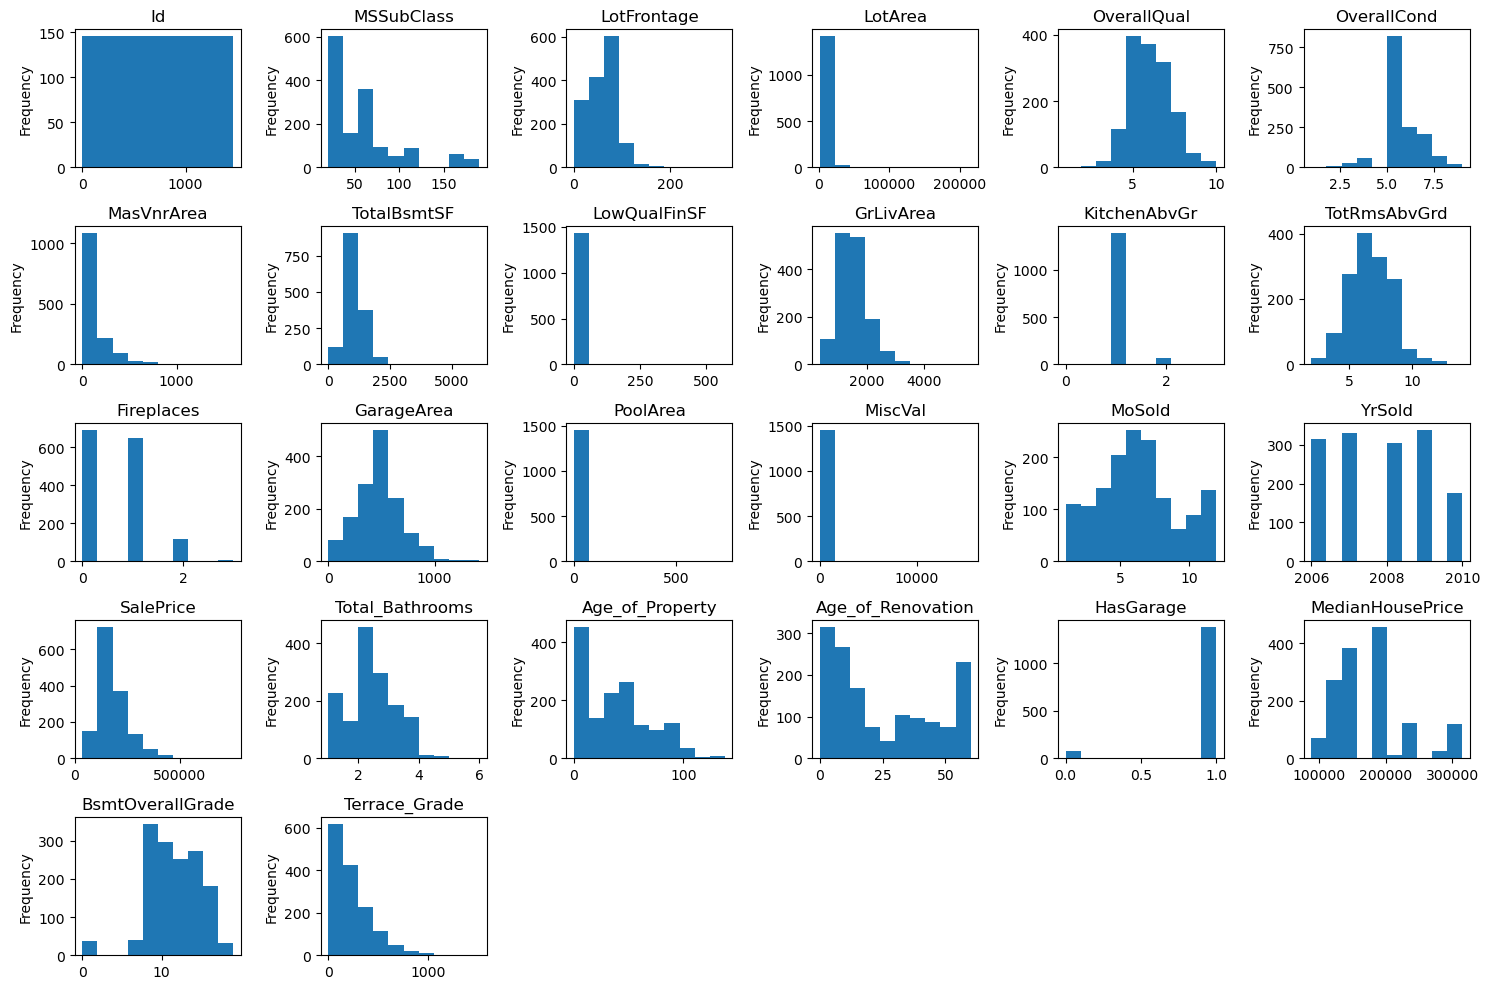

In [131]:
plot_histograms_for_all_numeric(df3)

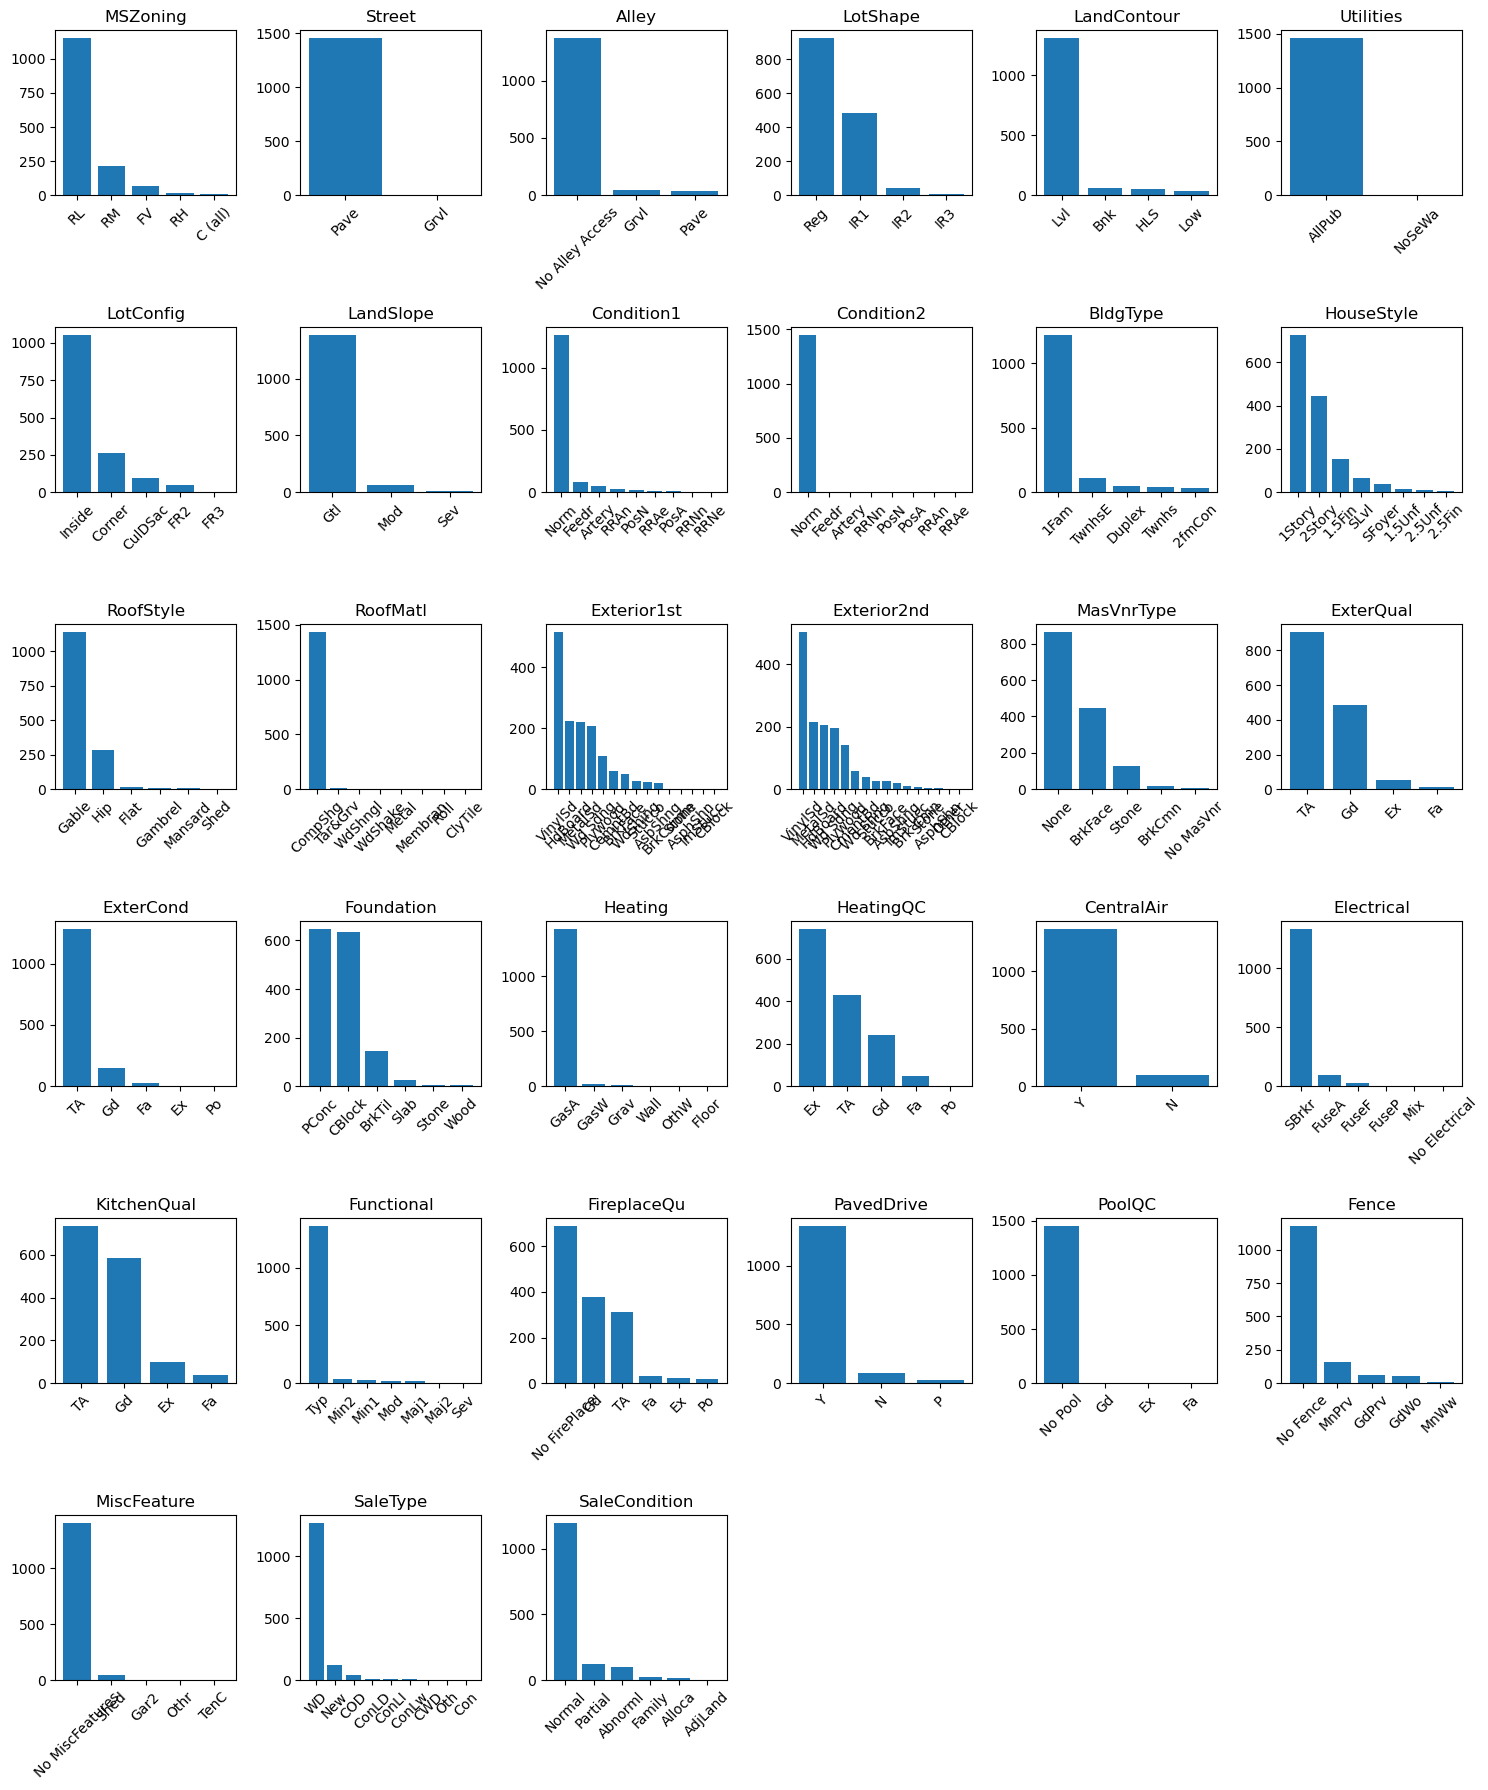

In [132]:
plot_barplot_all_categoric(df3)

In [133]:
# From scanning the visualizations, i wanted to stack the variables for checking them below
cat_feat_check_cardinality = ['Id', 'KitchenAbvGr', 'HasGarage', 'Street', 'Alley', 'Utilities', 
                              'Condition1', 'Condition2', 'RoofMatl', 'ExterCond', 'Heating', 'CentralAir', 
                              'Electrical', 'Functional', 'PavedDrive', 'PoolQC', 'MiscFeature', 'SaleType', 'SaleCondition'  ]
cont_feat_check_cardinalty = ['LowQualFinSF', 'PoolArea', 'MiscVal' ]

In [134]:
# I can Check the correlations of suspicious low-varied features with Target, if their effect is very low on target better to let them go
cardinality_drop_columns = []
for col in cont_feat_check_cardinalty:
    coref = df3[col].corr(df3['SalePrice'])
    if abs(coref) < 0.1:
        cardinality_drop_columns.append(col)
        print(f"Correlation of {col} with Sale Price is {coref}")

Correlation of LowQualFinSF with Sale Price is -0.02560613000067956
Correlation of PoolArea with Sale Price is 0.09240354949187322
Correlation of MiscVal with Sale Price is -0.02118957964030325


In [135]:
# I can check value_counts % of categorical and so called categorical variables
# I created a treshhold here (%3 and %97). If the observations are stacked in a single value within treshold limit, let them go 

for col in cat_feat_check_cardinality:
    vc_df = df3[col].value_counts(normalize=True).sort_values(ascending=False).reset_index()
    freq = round(vc_df.iloc[0,1], 3)
    value = vc_df.iloc[0,0]
    if (freq > 0.97) or (freq < 0.03):
        cardinality_drop_columns.append(col)
        print(f"{col.ljust(15)} -- {str(value).ljust(15)} -- {freq}")

Id              -- 1               -- 0.001
Street          -- Pave            -- 0.996
Utilities       -- AllPub          -- 0.999
Condition2      -- Norm            -- 0.99
RoofMatl        -- CompShg         -- 0.982
Heating         -- GasA            -- 0.978
PoolQC          -- No Pool         -- 0.995


In [136]:
cardinality_drop_columns

['LowQualFinSF',
 'PoolArea',
 'MiscVal',
 'Id',
 'Street',
 'Utilities',
 'Condition2',
 'RoofMatl',
 'Heating',
 'PoolQC']

In [137]:
df4 = df3.drop(columns=cardinality_drop_columns)

In [138]:
print(df3.shape, '--->', df4.shape)

(1460, 59) ---> (1460, 49)


## Outliers

In [139]:
# I have class in my library to deal with outliers, lets import and instantiate an object
from data.fatih_eda import FatihOutliers

In [140]:
outliers = FatihOutliers(df4)

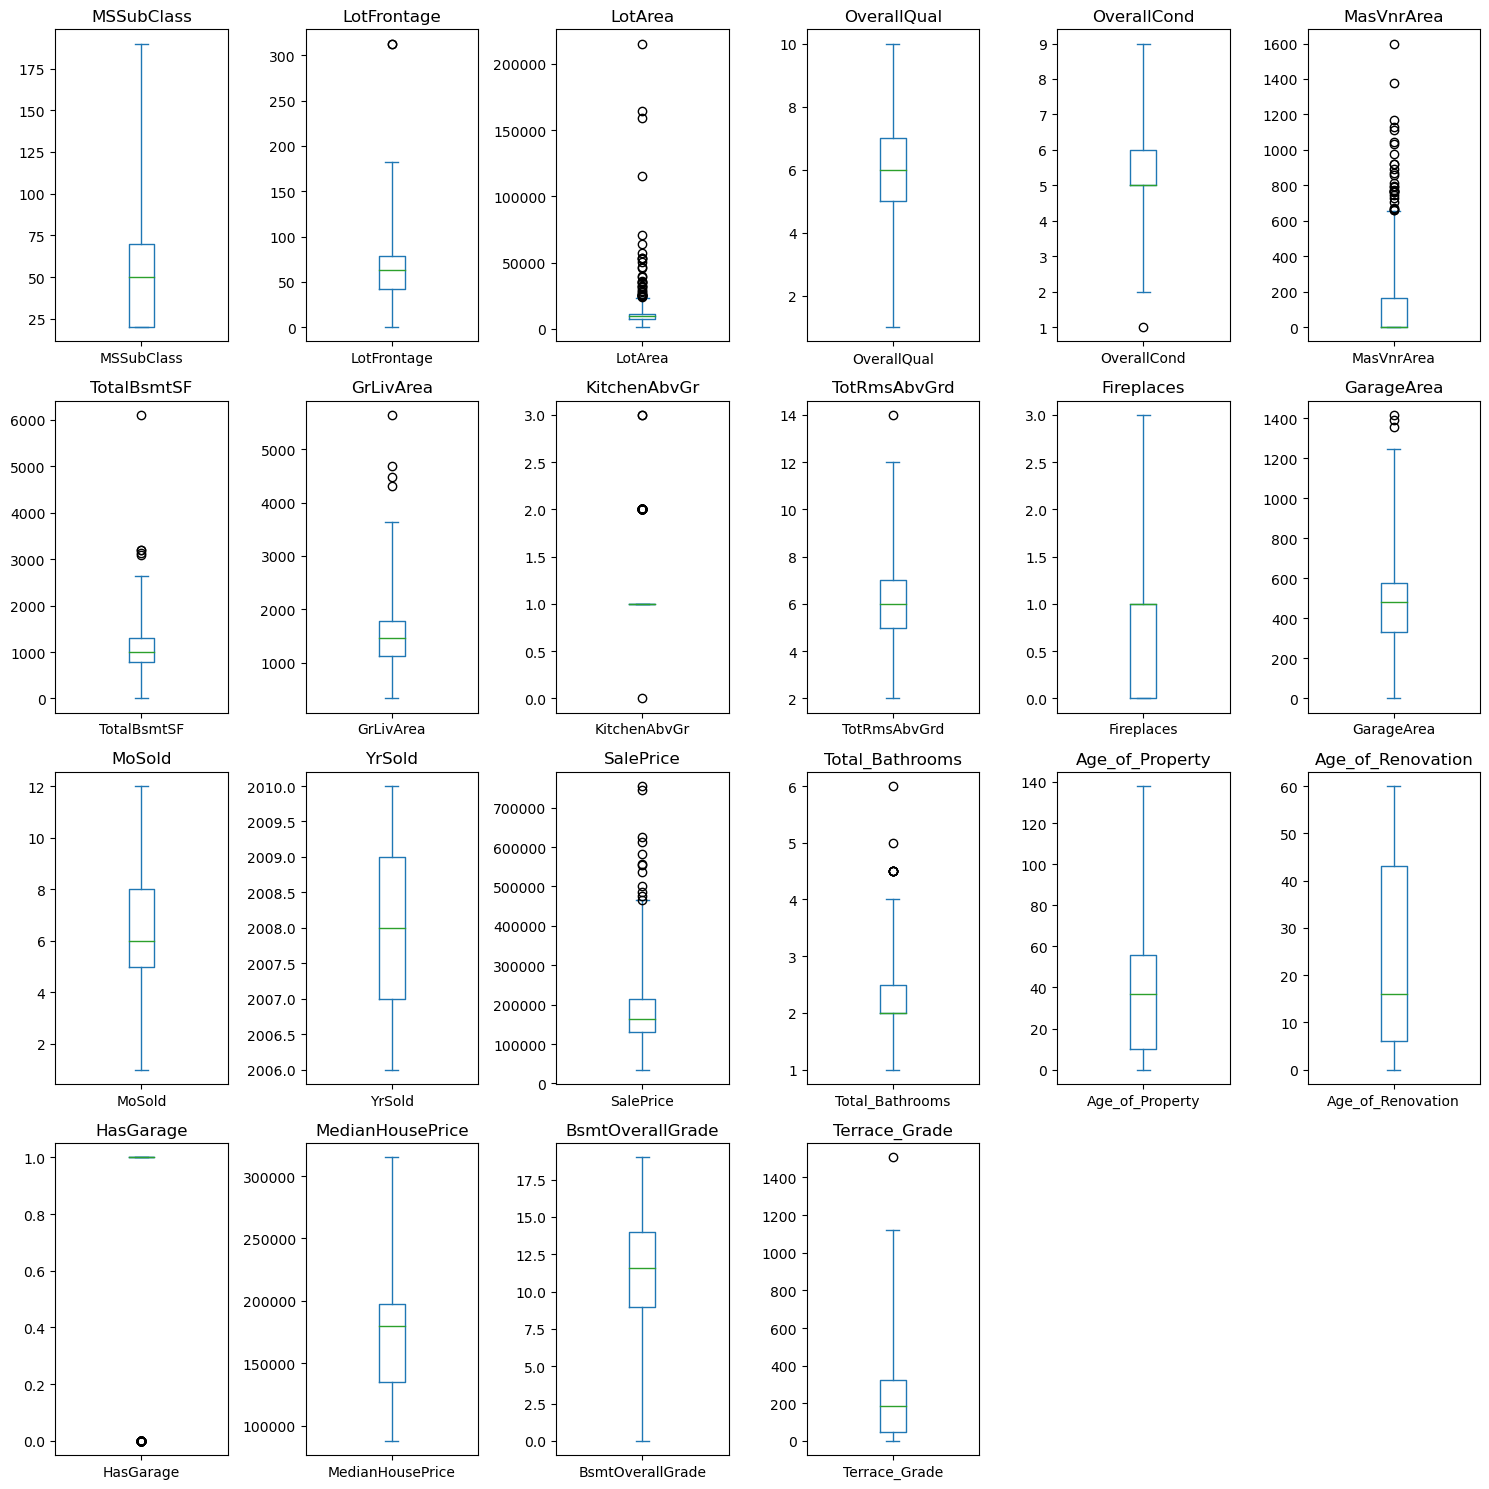

In [141]:
outliers.plot_boxplots_for_all_numeric(IQR_multi=3)

There are a lot of outliers in the dataset and this is a chalenging task since there is a tradeoff between holding the outliers or dropping them (or imputing, transforming). Altough boxplots show a general picture lets see some statistics related to outliers

In [142]:
outliers.show_outlier_stats(IQR_multi=3)

,OutlierCount
GarageArea,3
GrLivArea,4
HasGarage,81
KitchenAbvGr,68
LotArea,34
LotFrontage,2
MasVnrArea,28
OverallCond,1
SalePrice,12
Terrace_Grade,1


### Approach-1

Actually 249 is not the real number, Garage, Kitchen, MasVnrAre can be skipped due to their nature, but the rest are important outliers.  
Here is my **approach:**  
- Firstly i will be hesitant to remove much outliers
- Try to see the results, inspect residuals and etc
- Then will be more flexible do drop 
- Again inspect the results and compare which one is better

In [143]:
o1 = outliers.show_outliers_for_features('LotFrontage')
o1

,MSSubClass,MSZoning,LotFrontage,LotArea,Alley,LotShape,LandContour,LotConfig,LandSlope,Condition1,BldgType,HouseStyle,OverallQual,OverallCond,RoofStyle,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,TotalBsmtSF,HeatingQC,CentralAir,Electrical,GrLivArea,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageArea,PavedDrive,Fence,MiscFeature,MoSold,YrSold,SaleType,SaleCondition,SalePrice,Total_Bathrooms,Age_of_Property,Age_of_Renovation,HasGarage,MedianHousePrice,BsmtOverallGrade,Terrace_Grade
934,20,RL,313.0,27650,No Alley Access,IR2,HLS,Inside,Mod,PosA,1Fam,1Story,7,7,Flat,Wd Sdng,Wd Sdng,None,0.0,TA,TA,CBlock,585,Ex,Y,SBrkr,2069,1,Gd,9,Typ,1,Gd,505,Y,No Fence,No MiscFeatures,11,2008,WD,Normal,242000,3.0,50,3,1,140000.0,17.0,0
1298,60,RL,313.0,63887,No Alley Access,IR3,Bnk,Corner,Gtl,Feedr,1Fam,2Story,10,5,Hip,Stucco,Stucco,Stone,796.0,Ex,TA,PConc,6110,Ex,Y,SBrkr,5642,1,Ex,12,Typ,3,Gd,1418,Y,No Fence,No MiscFeatures,1,2008,New,Partial,160000,4.5,2,2,1,121750.0,18.0,506


In [144]:
o2 = outliers.show_outliers_for_features('MasVnrArea').sort_values(by='MasVnrArea', ascending=False).head(2)
o2

,MSSubClass,MSZoning,LotFrontage,LotArea,Alley,LotShape,LandContour,LotConfig,LandSlope,Condition1,BldgType,HouseStyle,OverallQual,OverallCond,RoofStyle,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,TotalBsmtSF,HeatingQC,CentralAir,Electrical,GrLivArea,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageArea,PavedDrive,Fence,MiscFeature,MoSold,YrSold,SaleType,SaleCondition,SalePrice,Total_Bathrooms,Age_of_Property,Age_of_Renovation,HasGarage,MedianHousePrice,BsmtOverallGrade,Terrace_Grade
297,60,FV,66.0,7399,Pave,IR1,Lvl,Inside,Gtl,Norm,1Fam,2Story,7,5,Hip,VinylSd,VinylSd,BrkFace,1600.0,Gd,TA,PConc,975,Ex,Y,SBrkr,1950,1,Gd,7,Typ,1,TA,576,Y,No Fence,No MiscFeatures,6,2007,WD,Normal,239000,2.5,13,12,1,225500.0,12.0,406
1169,60,RL,118.0,35760,No Alley Access,IR1,Lvl,CulDSac,Gtl,Norm,1Fam,2Story,10,5,Hip,HdBoard,HdBoard,BrkFace,1378.0,Gd,Gd,PConc,1930,Ex,Y,SBrkr,3627,1,Gd,10,Typ,1,TA,807,Y,No Fence,No MiscFeatures,7,2006,WD,Normal,625000,4.5,15,14,1,301500.0,18.0,437


In [145]:
o3 = outliers.show_outliers_for_features('TotalBsmtSF').sort_values(by='TotalBsmtSF', ascending=False).head(1)
o3

,MSSubClass,MSZoning,LotFrontage,LotArea,Alley,LotShape,LandContour,LotConfig,LandSlope,Condition1,BldgType,HouseStyle,OverallQual,OverallCond,RoofStyle,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,TotalBsmtSF,HeatingQC,CentralAir,Electrical,GrLivArea,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageArea,PavedDrive,Fence,MiscFeature,MoSold,YrSold,SaleType,SaleCondition,SalePrice,Total_Bathrooms,Age_of_Property,Age_of_Renovation,HasGarage,MedianHousePrice,BsmtOverallGrade,Terrace_Grade
1298,60,RL,313.0,63887,No Alley Access,IR3,Bnk,Corner,Gtl,Feedr,1Fam,2Story,10,5,Hip,Stucco,Stucco,Stone,796.0,Ex,TA,PConc,6110,Ex,Y,SBrkr,5642,1,Ex,12,Typ,3,Gd,1418,Y,No Fence,No MiscFeatures,1,2008,New,Partial,160000,4.5,2,2,1,121750.0,18.0,506


In [146]:
o4 = outliers.show_outliers_for_features('GrLivArea')
o4

,MSSubClass,MSZoning,LotFrontage,LotArea,Alley,LotShape,LandContour,LotConfig,LandSlope,Condition1,BldgType,HouseStyle,OverallQual,OverallCond,RoofStyle,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,TotalBsmtSF,HeatingQC,CentralAir,Electrical,GrLivArea,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageArea,PavedDrive,Fence,MiscFeature,MoSold,YrSold,SaleType,SaleCondition,SalePrice,Total_Bathrooms,Age_of_Property,Age_of_Renovation,HasGarage,MedianHousePrice,BsmtOverallGrade,Terrace_Grade
523,60,RL,130.0,40094,No Alley Access,IR1,Bnk,Inside,Gtl,PosN,1Fam,2Story,10,5,Hip,CemntBd,CmentBd,Stone,762.0,Ex,TA,PConc,3138,Ex,Y,SBrkr,4676,1,Ex,11,Typ,1,Gd,884,Y,No Fence,No MiscFeatures,10,2007,New,Partial,184750,4.5,3,2,1,121750.0,18.0,614
691,60,RL,104.0,21535,No Alley Access,IR1,Lvl,Corner,Gtl,Norm,1Fam,2Story,10,6,Gable,HdBoard,HdBoard,BrkFace,1170.0,Ex,TA,PConc,2444,Ex,Y,SBrkr,4316,1,Ex,10,Typ,2,Ex,832,Y,No Fence,No MiscFeatures,1,2007,WD,Normal,755000,4.0,16,15,1,301500.0,18.0,432
1182,60,RL,160.0,15623,No Alley Access,IR1,Lvl,Corner,Gtl,Norm,1Fam,2Story,10,5,Hip,Wd Sdng,ImStucc,None,0.0,Gd,TA,PConc,2396,Ex,Y,SBrkr,4476,1,Ex,10,Typ,2,TA,813,Y,MnPrv,No MiscFeatures,7,2007,WD,Abnorml,745000,4.5,14,14,1,301500.0,17.0,249
1298,60,RL,313.0,63887,No Alley Access,IR3,Bnk,Corner,Gtl,Feedr,1Fam,2Story,10,5,Hip,Stucco,Stucco,Stone,796.0,Ex,TA,PConc,6110,Ex,Y,SBrkr,5642,1,Ex,12,Typ,3,Gd,1418,Y,No Fence,No MiscFeatures,1,2008,New,Partial,160000,4.5,2,2,1,121750.0,18.0,506


In [147]:
o5 = outliers.show_outliers_for_features('TotRmsAbvGrd')
o5

,MSSubClass,MSZoning,LotFrontage,LotArea,Alley,LotShape,LandContour,LotConfig,LandSlope,Condition1,BldgType,HouseStyle,OverallQual,OverallCond,RoofStyle,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,TotalBsmtSF,HeatingQC,CentralAir,Electrical,GrLivArea,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageArea,PavedDrive,Fence,MiscFeature,MoSold,YrSold,SaleType,SaleCondition,SalePrice,Total_Bathrooms,Age_of_Property,Age_of_Renovation,HasGarage,MedianHousePrice,BsmtOverallGrade,Terrace_Grade
635,190,RH,60.0,10896,Pave,Reg,Bnk,Inside,Gtl,Feedr,2fmCon,2.5Fin,6,7,Hip,VinylSd,VinylSd,None,0.0,Fa,TA,CBlock,1440,Ex,Y,FuseA,3395,2,Fa,14,Typ,0,No FirePlace,0,N,No Fence,No MiscFeatures,3,2007,WD,Abnorml,200000,2.0,96,15,0,139500.0,8.0,110


In [148]:
o6 = outliers.show_outliers_for_features('Terrace_Grade')
o6

,MSSubClass,MSZoning,LotFrontage,LotArea,Alley,LotShape,LandContour,LotConfig,LandSlope,Condition1,BldgType,HouseStyle,OverallQual,OverallCond,RoofStyle,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,TotalBsmtSF,HeatingQC,CentralAir,Electrical,GrLivArea,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageArea,PavedDrive,Fence,MiscFeature,MoSold,YrSold,SaleType,SaleCondition,SalePrice,Total_Bathrooms,Age_of_Property,Age_of_Renovation,HasGarage,MedianHousePrice,BsmtOverallGrade,Terrace_Grade
1328,50,RM,60.0,10440,Grvl,Reg,Lvl,Corner,Gtl,Norm,1Fam,1.5Fin,6,7,Gable,BrkFace,Wd Sdng,None,0.0,Gd,Gd,BrkTil,1510,Ex,Y,SBrkr,2792,1,TA,8,Mod,2,TA,520,Y,MnPrv,Shed,6,2008,WD,Normal,256000,2.0,90,60,1,119000.0,10.0,1507


In [149]:
outliers_index_drop = list(set(list(o1.index) + list(o2.index) + list(o3.index) + list(o4.index) + list(o5.index) + list(o6.index)))
outliers_index_drop

[934, 297, 523, 1328, 1169, 1298, 691, 635, 1182]

In [150]:
df5 = df4.drop(index=outliers_index_drop)

In [151]:
print(df4.shape, ' ---> ', df5.shape)

(1460, 49)  --->  (1451, 49)


### Approach-2

**This is an iteration after first model run**  
This time i will be a bit more flexible to remove more outliers. I will focus on IQR 4

In [152]:
# I need to instantiate my handler again, since the dataframe changed
outliers = FatihOutliers(df5)

In [153]:
outliers.show_outlier_stats(IQR_multi=4)

,OutlierCount
HasGarage,80
KitchenAbvGr,67
LotArea,21
MasVnrArea,11
SalePrice,4
Total_Bathrooms,2
Total,185


In [154]:
df5.drop(index=outliers.show_outliers_for_features(col='LotArea', IQR_multi=4).index, inplace=True)

In [155]:
df5.drop(index=outliers.show_outliers_for_features(col='SalePrice', IQR_multi=4).index, inplace=True)

In [156]:
df5.drop(index=outliers.show_outliers_for_features(col='TotalBsmtSF', IQR_multi=4).index, inplace=True)

In [157]:
df5.shape

(1424, 49)

I have dropped 27 more observations in this iteration, but we will see the results is positive or negative.

# 2. Exploratory Data Analysis

## Exploring The Relationships with Target

### Numeric Variables

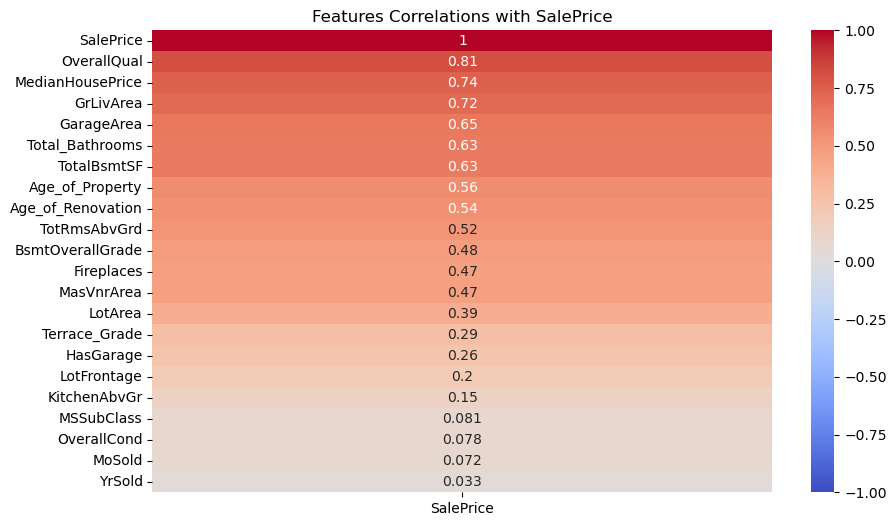

In [158]:
target_column = 'SalePrice'
corr_matrix = df5.corr()
corr_with_target = corr_matrix[target_column].apply(np.abs).sort_values(ascending=False)


plt.figure(figsize=(10, 6))
sns.heatmap(corr_with_target.to_frame(), annot=True, cmap='coolwarm', cbar=True, vmin=-1, vmax=1)
plt.title(f'Features Correlations with {target_column}')
plt.show()

There is a clear picture here as expected **OverallQual, MedianhousePrice, GrLivAre** are effecting sale price a lot. And some features dont really effect the sale price. I consider to remove them from my dataset

**What happened to --OVERALLCOND-- I think there is a room to improve and engineer this feature since its correlation far low than expected, i think it needs some transformation.**

**In the second iteration**, i didnt want to lose this variables to see their possible effect on the scores. But the code below is a playground whether to drop or hold this low correlated features. The **treshold below is 0.2** but can be changed

In [159]:
features_drop_low_correlation_numeric = []
# for i,v in corr_with_target.iteritems():
#     if (abs(v) < 0.2):
#         features_drop_low_correlation_numeric.append(i)
# features_drop_low_correlation_numeric

In [160]:
df7 = df5.drop(columns=features_drop_low_correlation_numeric)
print(df5.shape, ' ---> ', df7.shape)

(1424, 49)  --->  (1424, 49)


### Categorical Variables

Altough its not so common i want to check the correlations of categorical variables with the dependent variable, SalePrice. Firstly i will encode them temporarily to reach numeric values (it can be fine tuned with adding label encoding, but i just want to see general picture here), then combine each correlation into features 

In [161]:
categorical_columns = df7.select_dtypes(include='object').columns
categorical_columns

Index(['MSZoning', 'Alley', 'LotShape', 'LandContour', 'LotConfig',
       'LandSlope', 'Condition1', 'BldgType', 'HouseStyle', 'RoofStyle',
       'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond',
       'Foundation', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'PavedDrive', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')

In [162]:
df_encoded_temporary = pd.get_dummies(df7[categorical_columns], drop_first=True)

In [163]:
df_encoded_temporary['SalePrice'] = df7['SalePrice']
target_column = 'SalePrice'
corr_matrix = df_encoded_temporary.corr()
corr_with_target = corr_matrix[target_column].apply(np.abs).sort_values(ascending=False)

corr_with_target.nlargest(5)

SalePrice           1.000000
ExterQual_TA        0.617186
KitchenQual_TA      0.545280
Foundation_PConc    0.528042
ExterQual_Gd        0.498950
Name: SalePrice, dtype: float64

In [164]:
# Combine all dummy variable correlations into features

corr_of_categoric_columns = {}
for col in categorical_columns:
    corr_of_categoric_columns[col] = []
    vc = df7[col].value_counts(normalize=True)
    
    #iterate through corr matrix index and values
    for i,v in corr_with_target.items():
        c_sc = i.split('_')
        if col == c_sc[0]:
            
            #find the weight of sub-categories depending on frequncy
            weight = vc[c_sc[1]]
            corr_for_sub_cateory = v * weight
            corr_of_categoric_columns[col].append(corr_for_sub_cateory)
            
corr_of_categoric_columns = {key: sum(value) for key, value in corr_of_categoric_columns.items()}
corr_of_categoric_columns_df = pd.DataFrame(list(corr_of_categoric_columns.items()), columns=['Categorical Feature', 'Correlation with SalePrice'])
corr_of_categoric_columns_df.sort_values(by='Correlation with SalePrice', ascending=False).head(10)

,Categorical Feature,Correlation with SalePrice
13,ExterQual,0.553804
19,KitchenQual,0.430495
15,Foundation,0.392919
21,FireplaceQu,0.361069
12,MasVnrType,0.333594
25,SaleType,0.259383
0,MSZoning,0.250711
17,CentralAir,0.250537
18,Electrical,0.237195
22,PavedDrive,0.231990


I just wanted to hold all low correlated features by simply making treshold 0.00 after some iterations to see model performance, but anytime treshold can be changed to upper values

In [165]:
features_drop_low_correlation_categoric = corr_of_categoric_columns_df[corr_of_categoric_columns_df['Correlation with SalePrice']<0.00] \
                                         ['Categorical Feature'].to_list()

In [166]:
features_drop_low_correlation_categoric

[]

In [167]:
df8 = df7.drop(columns=features_drop_low_correlation_categoric)
print(df7.shape, ' ---> ', df8.shape)


(1424, 49)  --->  (1424, 49)


## Relationships Among Independent Variables & MultiCollinearity

Its inevitable to have multicollinearity in a dataset with 81 features and all related to a single property. Many features can easily explain each other in a certain degree. I will look for help of Correlations, Variance Inflation Factor (VIF) and Cramer's V to address multicollinearity

### Correlations and Eigenvalues

In [168]:
# Correlation Matrix of Numeric Variables
df8.drop(columns=['SalePrice']).corr()[
                                        (df8.drop(columns=['SalePrice']).corr() >=0.8) &
                                        (df8.drop(columns=['SalePrice']).corr() <1)
                                       ]

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,MasVnrArea,TotalBsmtSF,GrLivArea,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageArea,MoSold,YrSold,Total_Bathrooms,Age_of_Property,Age_of_Renovation,HasGarage,MedianHousePrice,BsmtOverallGrade,Terrace_Grade
MSSubClass,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LotFrontage,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LotArea,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
OverallQual,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
OverallCond,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MasVnrArea,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TotalBsmtSF,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GrLivArea,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.830391,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
KitchenAbvGr,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TotRmsAbvGrd,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.830391,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [169]:
# Eigenvalues of correlation matrix for numeric variables
eigenvalues, _ = np.linalg.eig(df8.drop(columns=['SalePrice']).corr())

# Print the eigenvalues
print("Eigenvalues:")
print(eigenvalues)

Eigenvalues:
[5.79611377 2.0741079  1.7382729  1.3147393  0.10838065 0.18949337
 0.23110635 0.24315916 0.30009634 0.32581985 0.41038163 1.15609563
 1.09430677 1.02333111 0.51766652 0.55233408 0.6581411  0.76436594
 0.8038951  0.86454023 0.83365229]


**TotRmsAbvGrd and GrLivArea** represents a degree of multi collinearity. Maybe i could choose **Bedrooms Above Ground** rather than total rooms abv grd  
**Eigenvalues** are not very close to Zero, so it doesnt directly refer a multicollinearity issues

### Variance Inflation Factor (VIF)

**VIF is used for numeric features. however if encoded properly it can address multicollinearity for categorical variables as well. Lets see both:**

In [171]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [172]:
df_encoded_temporary = pd.get_dummies(df8.select_dtypes(include='object'), drop_first=True)
df_combined_temporary = pd.concat([df8.select_dtypes(include='number'), df_encoded_temporary], axis=1).drop(columns=['SalePrice'])

# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data["feature"] = df_combined_temporary.columns
vif_data["VIF"] = [variance_inflation_factor(df_combined_temporary.values, i) for i in range(df_combined_temporary.shape[1])]

vif_data.sort_values(by='VIF', ascending=False).head(15)

,feature,VIF
80,Exterior2nd_CBlock,inf
66,Exterior1st_CBlock,inf
13,YrSold,3067.197844
138,MiscFeature_No MiscFeatures,999.987681
102,ExterCond_TA,488.204646
58,RoofStyle_Gable,210.014538
23,MSZoning_RL,157.630624
74,Exterior1st_VinylSd,154.575769
89,Exterior2nd_VinylSd,141.938004
126,Functional_Typ,128.320888


**VIF gives too much inspirations**  
  
**1. Overall Quality** has very high VIF, we also observed this in correlation matrix it has positive bonds with some other features but none of them is more than 0.8. This is actually very normal since it is some sort of a summary of the house. Moreover, it has 0.8 correlation with SalesPrice, so i will **not drop** it but i surely will think more of this and its related features, after initial model results.    
  
**2. TotRmsAbvGrd and  GrLivArea** also priduced high VIf. we also observed this in correlation matrix. And as general domain knowledge this is normal. However i will **not remove** this combination. **BUT** when i iterate the model with other combinations i will choose to drop one or change one with **TotalBedroomsAbvGrd**  
  
**3. HasGarage GarageAre** i think i need to **drop** this since GarageArea and HasGarage is correlated because if GarageArea is 0 then HasGarage is also 0  
  
for a detailed eye, there are more inferences but i think this is enough for now

### Cramers V

**Cramers V is used for categorical variables only**

Cramér's V is a suitable measure for associations between categorical variables. It provides a value between 0 and 1, where 0 indicates no association and 1 indicates a perfect association. This metric gives you a good sense of the strength of association between categorical variables.

In [69]:
from data.fatih_eda import calculate_cramersV

In [70]:
calculate_cramersV(df8, df8.select_dtypes(include='object').columns, treshold=0.4)

{('LandContour', 'LandSlope'): 0.4142264576033563,
 ('LandSlope', 'LandContour'): 0.4142264576033563,
 ('Exterior1st', 'Exterior2nd'): 0.7636268236050636,
 ('Exterior2nd', 'Exterior1st'): 0.7636268236050636,
 ('ExterQual', 'KitchenQual'): 0.53177219901877,
 ('CentralAir', 'Electrical'): 0.42691983513416615,
 ('Electrical', 'CentralAir'): 0.42691983513416615,
 ('KitchenQual', 'ExterQual'): 0.53177219901877,
 ('SaleType', 'SaleCondition'): 0.4766022582240813,
 ('SaleCondition', 'SaleType'): 0.47660225822408137}

**'KitchenQual', 'ExterQual'** : It seems like there is a strong association between two pairs. Also: VIF scored showed similar results. I think this association can be real since, the quality of one part of the home can be associated to another part. Since ExterQual has a higher correlation with SalesPrice, i will **drop KitchenQual** from the dataset. I will also drop **Exterior2nd**

### Drop Columns for Multicollinearity

In [71]:
df9 = df8.drop(columns=['HasGarage', 'KitchenQual', 'Exterior2nd'])
print(df8.shape, ' ---> ', df9.shape)

(1424, 49)  --->  (1424, 46)


**Test Data**

In [72]:
df_test_4 = df_test_3.drop(columns=cardinality_drop_columns)
# df4 --> df5 outliers (we did not drop any columns but only observations from training data in outliers section)
df_test_6 = df_test_4.drop(columns=features_drop_low_correlation_numeric)  
df_test_8 = df_test_6.drop(columns=features_drop_low_correlation_categoric)
df_test_9 = df_test_8.drop(columns=['HasGarage', 'KitchenQual', 'Exterior2nd'])
print(df_test_9.shape)

(1459, 45)


## Observing Distributions and Skewnesses & Transformations

In [73]:
from data.fatih_eda import plot_histograms_for_all_numeric, plot_barplot_all_categoric

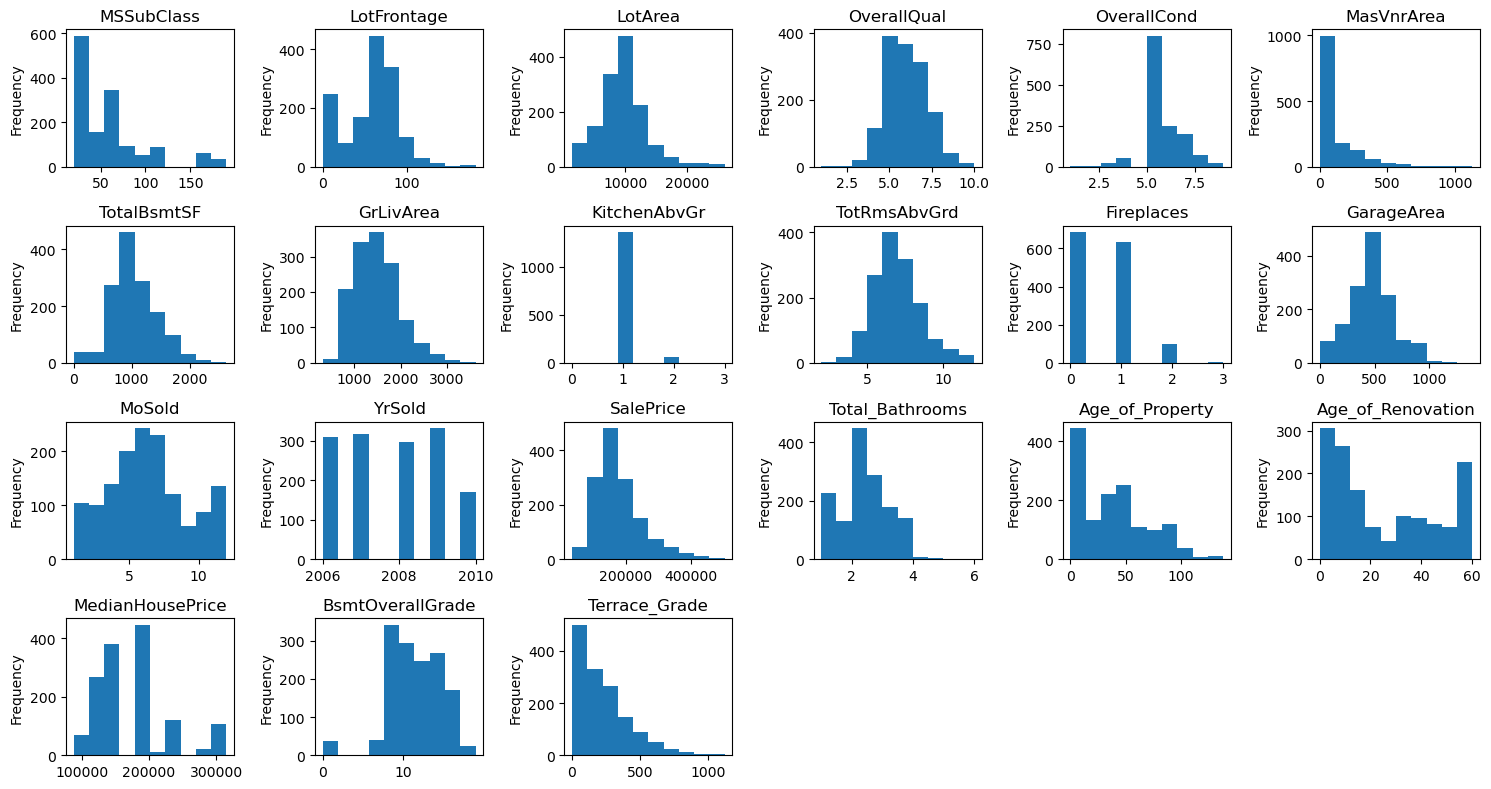

In [74]:
plot_histograms_for_all_numeric(df9)

**Apply Log Transformation to Skewed Features**

In [75]:
log_transform_num_columns = ['SalePrice', 'LotArea']
small_constant = 0.001   # this is to prevent infinity after log transformation

df9[log_transform_num_columns] = np.log(df9[log_transform_num_columns] + small_constant)

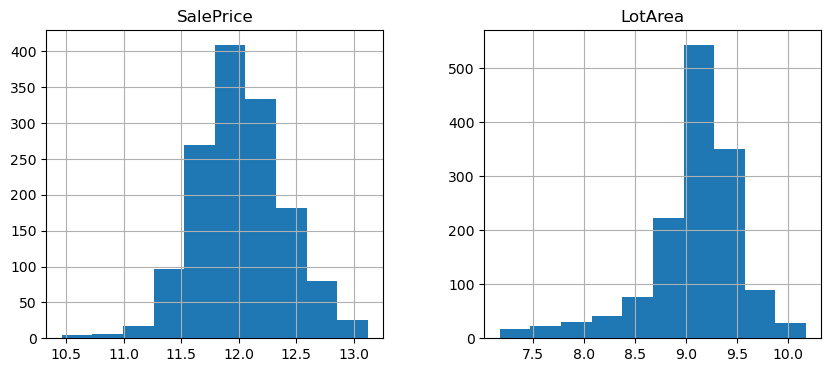

In [76]:
df9[['SalePrice', 'LotArea']].hist(figsize=(10,4));

**Test Data**

In [77]:
small_constant = 0.001   # this is to prevent infinity after log transformation
df_test_9['LotArea'] = np.log(df_test_9['LotArea'] + small_constant)

# 3. Data Transformations

## Encoding

In [78]:
categorical_columns = df9.select_dtypes(include='object').columns

In [79]:
ordinal_mapping = {
    'Street': {'Grvl':1, 'Pave':2},
    'Alley' : {'Grvl':1, 'Pave':2, 'No Alley Access':0},
    'LotShape' : {'IR3':1, 'IR2':2, 'IR1':3, 'Reg':4 },
    'LandContour' : {'Low':1, 'HLS':2, 'Bnk':3, 'Lvl':4 },
    'LandSlope' : {'Sev':1, 'Mod':2, 'Gtl':3},
    'ExterQual': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1},
    'ExterCond': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1},
    'BsmtQual': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'No Basement': 0},
    'BsmtCond': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'No Basement': 0},
    'BsmtExposure': {'Gd': 4, 'Av': 3, 'Mn': 2, 'No':1, 'No Basement': 0},
    'BsmtFinType2': {'GLQ': 6, 'ALQ': 5, 'BLQ': 4, 'Rec': 3, 'LwQ': 2, 'Unf': 1, 'No Basement': 0},
    'BsmtFinType1': {'GLQ': 6, 'ALQ': 5, 'BLQ': 4, 'Rec': 3, 'LwQ': 2, 'Unf': 1, 'No Basement': 0},    
    'HeatingQC': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1},
    'KitchenQual': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1},
    'FireplaceQu': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'No FirePlace': 0},
    'GarageQual': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'No Garage': 0},
    'GarageCond': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'No Garage': 0},
    'GarageFinish': {'Fin': 3, 'RFn': 2, 'Unf': 1, 'No Garage': 0},
    'PavedDrive': {'Y': 3, 'P': 2, 'N': 1},
    'PoolQC': {'Ex': 4, 'Gd': 3, 'TA': 2, 'Fa': 1, 'No Pool': 0},
    'Fence': {'GdPrv': 4, 'MnPrv': 3, 'GdWo': 2, 'MnWw': 1, 'No Fence': 0},        
    'Functional': {'Typ': 8, 'Min1': 7, 'Min2': 6, 'Mod': 5, 'Maj1': 4, 'Maj2': 3, 'Sev': 2, 'Sal': 1},
    'CentralAir': {'Y': 1, 'N': 0}
}

In [80]:
# Apply Ordinal Encoding
for var in categorical_columns:
    if var in ordinal_mapping.keys():
        df9[var] = df9[var].map(ordinal_mapping[var])

In [81]:
# Apply Nominal Encoding
nominal_categorical_vars = [col for col in categorical_columns if col not in ordinal_mapping.keys()]
df_encoded = pd.get_dummies(df9[nominal_categorical_vars], columns=nominal_categorical_vars)
df9 = pd.concat([df9, df_encoded], axis=1)
df10 = df9.drop(columns=nominal_categorical_vars)

In [82]:
df10.shape

(1424, 123)

**Test Data**

In [83]:
# Apply Ordinal Encoding
for var in categorical_columns:
    if var in ordinal_mapping.keys():
        df_test_9[var] = df_test_9[var].map(ordinal_mapping[var])

In [84]:
# Apply Nominal Encoding
df_encoded = pd.get_dummies(df_test_9[nominal_categorical_vars], columns=nominal_categorical_vars)
df_test_9 = pd.concat([df_test_9, df_encoded], axis=1)
df_test_10 = df_test_9.drop(columns=nominal_categorical_vars)
df_test_10.drop
print(df_test_10.shape)

(1459, 116)


## Aligning Datas if Needed

In [85]:
is_columns_aligned(df10, df_test_10)

Train and test datasets have different columns.
Columns in train but not in test: {'MiscFeature_TenC', 'Exterior1st_Stone', 'Electrical_Mix', 'HouseStyle_2.5Fin', 'Electrical_No Electrical', 'Exterior1st_ImStucc', 'SalePrice'}
Columns in test but not in train: set()


**4 columns have extra values in train data but not exist in test data**  
this will bring **7 extra columns** ---> i can drop them or replace with a similar value  

In [86]:
df10['HouseStyle_2Story']  = df10['HouseStyle_2.5Fin'] + df10['HouseStyle_2Story']
df10['Exterior1st_AsphShn'] = df10['Exterior1st_Stone'] + df10['Exterior1st_ImStucc'] + df10['Exterior1st_AsphShn']
df10['Electrical_FuseP'] = df10['Electrical_Mix'] + df10['Electrical_No Electrical'] + df10['Electrical_FuseP']
df10['MiscFeature_Othr']  = df10['MiscFeature_TenC'] + df10['MiscFeature_Othr']

df10.drop(columns=['HouseStyle_2.5Fin', 'Exterior1st_ImStucc', 'Exterior1st_Stone', 'Electrical_Mix', 'Electrical_No Electrical', 'MiscFeature_TenC'], inplace=True)

In [87]:
is_columns_aligned(df10, df_test_10)

Train and test datasets have different columns.
Columns in train but not in test: {'SalePrice'}
Columns in test but not in train: set()


---------------------------------------------------

## Feature & Target Dataset

In [88]:
X = df10.drop(columns = ['SalePrice'])
y = df10['SalePrice']
X_real_test = df_test_10

In [89]:
print(f"X shape is: {X.shape}")
print(f"y shape is: {y.shape}")
print(f"X test for Kaggle Predictions shape is: {X_real_test.shape}")

X shape is: (1424, 116)
y shape is: (1424,)
X test for Kaggle Predictions shape is: (1459, 116)


# 4. Model Building

## Train Test Split

In [90]:
from sklearn.model_selection import train_test_split

In [91]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"X_train shape is: {X_train.shape}")
print(f"y_train shape is: {y_train.shape}")
print(f"X_test shape is: {X_test.shape}")
print(f"y_test shape is: {y_test.shape}")

X_train shape is: (1139, 116)
y_train shape is: (1139,)
X_test shape is: (285, 116)
y_test shape is: (285,)


## Standardizing or Normalizing

For regression tasks, it's generally a good practice to standardize the features rather than normalizing them.  
Standardization (or Z-score scaling) is often preferred because it centers the data around a mean of 0 and scales it based on the standard deviation.  
This can be particularly helpful for models like linear regression, support vector machines, and neural networks, as they often assume that the features are normally distributed.

In [92]:
from sklearn.preprocessing import StandardScaler

In [93]:
standard_scaler = StandardScaler()

In [94]:
X_train_standardized = standard_scaler.fit_transform(X_train)
X_train_standardized_df = pd.DataFrame(X_train_standardized, columns=X_train.columns)

In [95]:
X_test_standardized = standard_scaler.transform(X_test)
X_test_standardized_df = pd.DataFrame(X_test_standardized, columns=X_test.columns)

In [96]:
X_real_test_standardized = standard_scaler.transform(X_real_test)
X_real_test_standardized_df = pd.DataFrame(X_real_test_standardized, columns=X_real_test.columns)

## Creating a Baseline Model

Lets start by building a simple baseline model.  
This can be a very basic model, such as predicting the mean or median of the target variable for every observation.  
This provides a starting point for comparison with more complex models.

In [97]:
from sklearn.metrics import mean_squared_error

In [98]:
baseline_prediction = y_train.mean()
baseline_mse = mean_squared_error(y_test, [baseline_prediction] * len(y_test))
baseline_rmse = baseline_mse**0.5
baseline_rmse

0.38001713445246177

## Initial Model Run

We will train following models with default parametres to compare scores:  
* linear regression  
* ridge regression  
* lasso regression  
* random forest regression  
* gradient boosting regression

In [99]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import cross_val_score

In [100]:
models = [
    ('Linear Regression', LinearRegression()),
    ('Ridge Regression', Ridge(random_state=42)),
    ('Lasso Regression', Lasso(random_state=42)), 
    ('Random Forest Regression', RandomForestRegressor(random_state=42)),
    ('Gradient Boosting Regression', GradientBoostingRegressor(random_state=42)) 
]

# Define a container to hold predictions
all_y_preds = {}

# Train and evaluate models
for name, model in models:
    # Train the model
    model.fit(X_train_standardized, y_train)
    
    # Perform cross-validation (where applicable)
    if name not in ['Linear Regression', 'Ridge Regression', 'Lasso Regression']:
        cross_val_scores = cross_val_score(model, X_train_standardized, y_train, cv=5, scoring='neg_mean_squared_error')
        rmse_scores = np.sqrt(-cross_val_scores)
        avg_rmse = np.mean(rmse_scores)
        print(f'{name} (Cross-Validation) - Average RMSE: {avg_rmse:.4f}')
    
    # Evaluate on the test set
    y_pred = model.predict(X_test_standardized)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    print(f'{name} - RMSE: {rmse:.4f}')
    
    # Store predictions in the container
    all_y_preds[name] = y_pred

Linear Regression - RMSE: 0.1195
Ridge Regression - RMSE: 0.1194
Lasso Regression - RMSE: 0.3800
Random Forest Regression (Cross-Validation) - Average RMSE: 0.1353
Random Forest Regression - RMSE: 0.1274
Gradient Boosting Regression (Cross-Validation) - Average RMSE: 0.1249
Gradient Boosting Regression - RMSE: 0.1141


## Residuals

**I was expecting a bit better results, lets check residuals to gain insights**  
UPDATE: i removed more outliers end increase score around %15

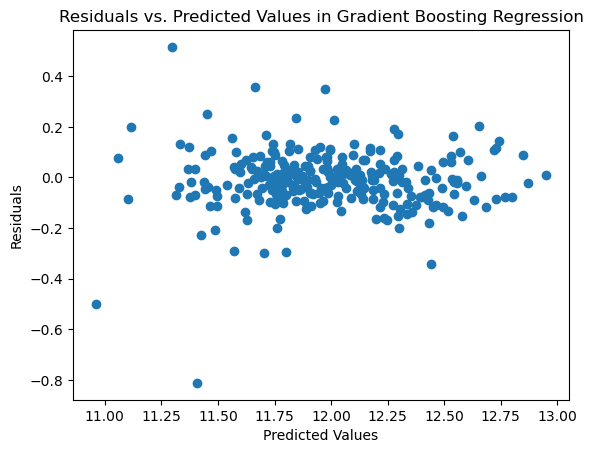

In [101]:
model_name_for_residual_plotting = 'Gradient Boosting Regression'
y_pred_for_residuals = all_y_preds[model_name_for_residual_plotting]
residuals = y_test - y_pred_for_residuals

# Scatter plot of residuals vs. predicted values
plt.scatter(y_pred, residuals)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title(f'Residuals vs. Predicted Values in {model_name_for_residual_plotting}')
plt.show()


In [102]:
r_sorted = residuals.apply(np.abs).sort_values(ascending=False)
r_sorted.head(30).index

Int64Index([  30,  970,  495,  142,  607,   66, 1062,  972,  589, 1443, 1020,
             264, 1414,  242,  112, 1362, 1000,  744,  114,  631, 1127, 1415,
            1186, 1139,  991,  885, 1063,  530, 1340,  881],
           dtype='int64')

# 5. Hyperparameter Tuning

**Gradient Boosting Regressor outperformed the others, so i wanted to optimize it**

In [103]:
from sklearn.model_selection import GridSearchCV

# Define the hyperparameters and their possible values
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 3, 4]
}

# Initialize the Gradient Boosting Regressor
model_gb = GradientBoostingRegressor(random_state=42)

# Set up Grid Search
grid_search = GridSearchCV(model_gb, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

In [104]:
grid_search.fit(X_train_standardized, y_train)

GridSearchCV(cv=5, estimator=GradientBoostingRegressor(random_state=42),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 4, 5], 'min_samples_split': [2, 3, 4],
                         'n_estimators': [50, 100, 200]},
             scoring='neg_mean_squared_error')

In [105]:
# Retreiving the best parameters
best_params = grid_search.best_params_
best_params

{'learning_rate': 0.1,
 'max_depth': 3,
 'min_samples_split': 2,
 'n_estimators': 200}

In [106]:
# Use best parameters to train and evaluate the model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_standardized)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
rmse

0.11142215789924212

In [107]:
feature_importances_df = pd.DataFrame({'Features': X.columns, 'Importances': best_model.feature_importances_}).sort_values(by='Importances', ascending=False)

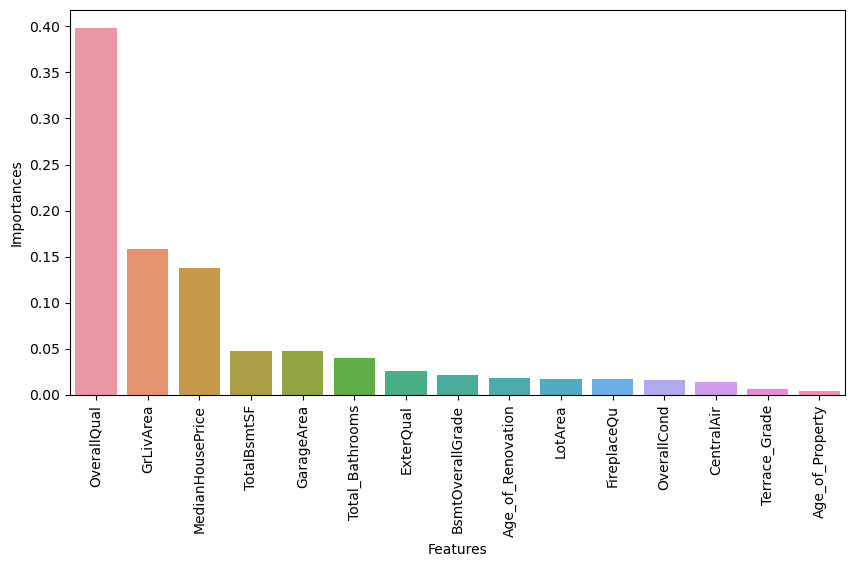

In [108]:
fig, ax = plt.subplots(figsize=(10,5))
sns.barplot(x='Features', y='Importances', data=feature_importances_df.head(15))
plt.xticks(rotation=90)
plt.show();

# 6. Make Final Predictions and Submission File